# Compare site and REZ power

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [5]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "01:00:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P dt6",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41571 instead
  warnings.warn(


In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [6]:
client

<Client: 'tcp://10.6.121.2:39169' processes=24 threads=24, memory=89.52 GiB>

In [7]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [8]:
%cd /g/data/w42/dr6273/work/power_models/

/g/data/w42/dr6273/work/power_models


### Load site power

In [9]:
regions = ["NSW", "QLD", "VIC", "SA", "TAS"]

In [10]:
path_power = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"

#### Wind power

- Using van der Wiel et al (2019) wind turbine fit to obtain capacity factors
- Wind facilities from OpenNEM as on July 2024

In [11]:
wind_site = xr.open_mfdataset(
    path_power + "wind/power/wind_power_state_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [12]:
wind_site = wind_site.sel(region=regions).power

In [107]:
wind_site.scale_factor_2023.values

array([1.99812231, 3.83751052, 2.39224606, 1.5772023 , 1.29675149])

In [78]:
wsite = (1e-6 * wind_site).sum("region").resample(time="1YS").sum()

In [79]:
wsite_sc = (1e-6 * wind_site * wind_site.scale_factor_2023).sum("region").resample(time="1YS").sum()

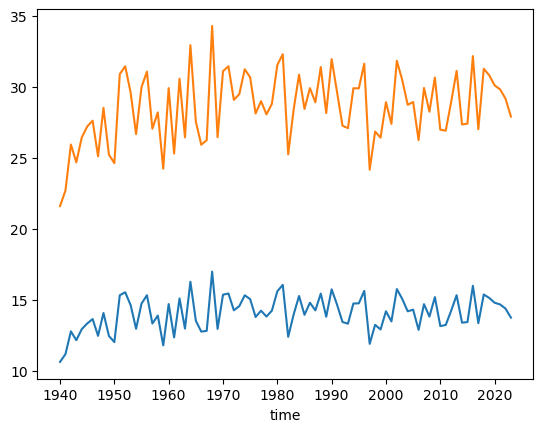

In [80]:
wsite.plot()
wsite_sc.plot()

#### Solar power
- Using van der Wiel et al (2019) solar panel fit to obtain capacity factors
- Solar facilities from OpenNEM as on July 2024

In [13]:
solar_site = xr.open_mfdataset(
    path_power + "solar/power/solar_power_state_van_der_Wiel_era5_hourly_1940-2023.nc"
)

In [14]:
solar_site = solar_site.sel(region=regions).power

In [108]:
solar_site.scale_factor_2023.values

array([0.81656467, 0.94635863, 0.81572369, 0.93289046, 1.        ])

In [81]:
ssite = (1e-6 * solar_site).sum("region").resample(time="1YS").sum()

In [82]:
ssite_sc = (1e-6 * solar_site * solar_site.scale_factor_2023).sum("region").resample(time="1YS").sum()

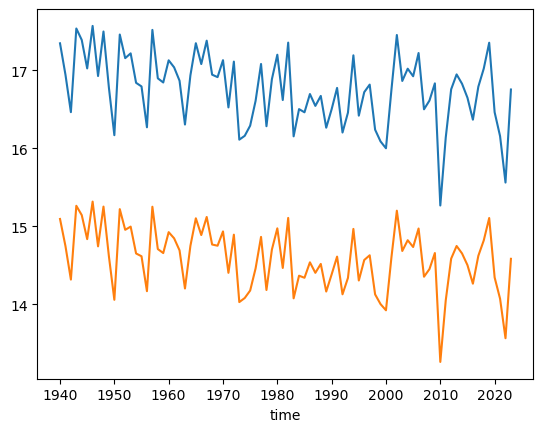

In [84]:
ssite.plot()
ssite_sc.plot()

### Load REZ power

With higher capacity factor grid cells given more generation capacity

In [45]:
wind_rez = xr.open_mfdataset(
    path_power + "REZ_power_existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc"
).power

In [46]:
solar_rez = xr.open_mfdataset(
    path_power + "REZ_power_existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc"
).power

In [60]:
wrez = 1e-6 * wind_rez.sum("REZ").resample(time="1YS").sum()

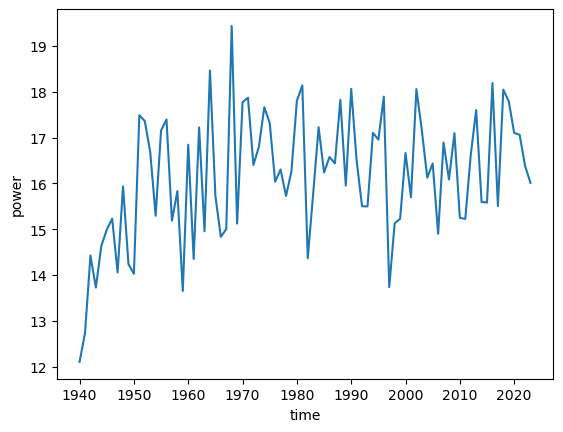

In [61]:
wrez.plot()

In [62]:
srez = 1e-6 * solar_rez.sum("REZ").resample(time="1YS").sum()

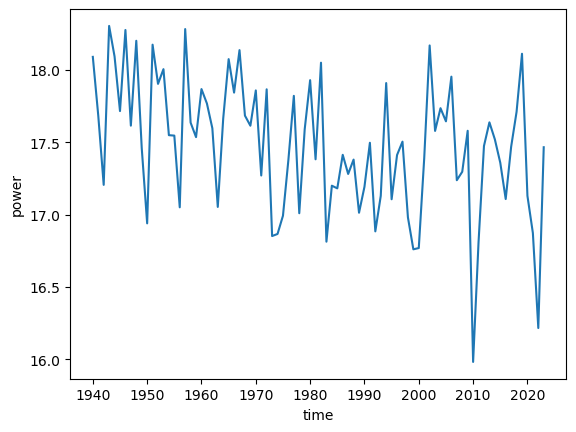

In [63]:
srez.plot()

Compare this to equal weighting across grid cells

In [17]:
wind_rez_even = xr.open_mfdataset(
    path_power + "REZ_power_even_weights_existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc"
).power

In [18]:
solar_rez_even = xr.open_mfdataset(
    path_power + "REZ_power_even_weights_existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc"
).power

## Comparison

In [66]:
def get_REZ_for_state(ds, state):
    """
    Return list of REZ names for state
    
    ds: dataset with REZ dimension
    state: str, code or for state e.g. NSW, SA
    """
    return [i for i in ds.REZ.values if i[0] == state[0]]

In [104]:
da_list = []
for state in regions:
    d = wind_rez.sel(REZ=get_REZ_for_state(wind_rez, state)).sum("REZ")
    ds = d * wind_site.scale_factor_2023.sel(region=state) * 1e-6
    ds = ds.resample(time="1YS").sum()
    ds = ds.expand_dims({"region": [state]})
    da_list.append(ds)
wrez_sc = xr.concat(da_list, dim="region").sum("region")

In [100]:
da_list = []
for state in regions:
    d = solar_rez.sel(REZ=get_REZ_for_state(solar_rez, state))
    ds = d * solar_site.scale_factor_2023.sel(region=state)
    ds = ds.sum("REZ").expand_dims({"region": [state]})
    da_list.append(ds)
srez_sc = xr.concat(da_list, dim="region").sum("region")

In [20]:
# fig, ax = plt.subplots(3, 2)

# for i, s in enumerate(regions):
#     rezs = get_REZ_for_state(wind_rez, s)
#     wind_site.sel(region=s).coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], label="Sites")
#     wind_rez.sel(REZ=rezs).sum("REZ").coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], label="REZ (weighted)")
#     wind_rez_even.sel(REZ=rezs).sum("REZ").coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], ls="--", label="REZ (even)")
#     ax.flatten()[i].set_title(s)
    
# ax[2,1].axis("off")
# plt.tight_layout()
# ax[2,0].legend(loc=(1.3, 0.2))

In [65]:
# fig, ax = plt.subplots(3, 2)

# for i, s in enumerate(regions):
#     rezs = get_REZ_for_state(wind_rez, s)
#     wind_site.sel(region=s).resample(time="1YS").sum().plot(ax=ax.flatten()[i], label="Sites")
#     wind_rez.sel(REZ=rezs).sum("REZ").resample(time="1YS").sum().plot(ax=ax.flatten()[i], label="REZ (weighted)")
#     wind_rez_even.sel(REZ=rezs).sum("REZ").resample(time="1YS").sum().plot(ax=ax.flatten()[i], ls="--", label="REZ (even)")
#     ax.flatten()[i].set_title(s)
    
# ax[2,1].axis("off")
# plt.tight_layout()
# ax[2,0].legend(loc=(1.3, 0.2))

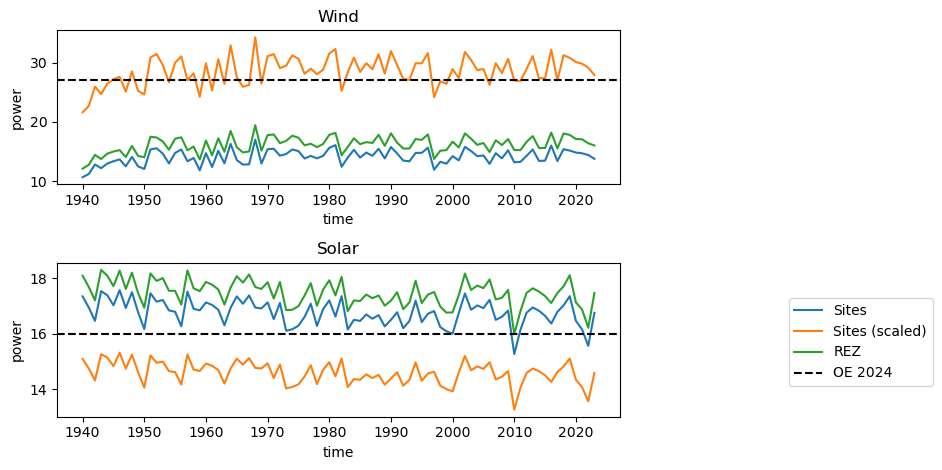

In [110]:
fig, ax = plt.subplots(2, 1)

# Wind
wsite.plot(ax=ax[0], label="Sites")
wsite_sc.plot(ax=ax[0], label="Sites (scaled)")
wrez.plot(ax=ax[0], label="REZ")
# wrez_sc.plot(ax=ax[0], label="REZ (scaled)")
ax[0].axhline(27, c="k", ls="--", label="OE 2024")
ax[0].set_title("Wind")

# Solar
ssite.plot(ax=ax[1], label="Sites")
ssite_sc.plot(ax=ax[1], label="Sites (scaled)")
srez.plot(ax=ax[1], label="REZ")
ax[1].axhline(16, c="k", ls="--", label="OE 2024")
ax[1].set_title("Solar")
    
plt.tight_layout()
ax[1].legend(loc=(1.3, 0.2))

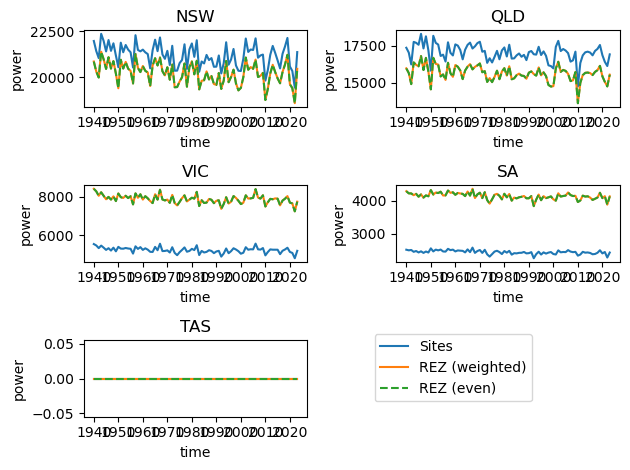

In [19]:
fig, ax = plt.subplots(3, 2)

for i, s in enumerate(regions):
    rezs = get_REZ_for_state(solar_rez, s)
    solar_site.sel(region=s).coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], label="Sites")
    solar_rez.sel(REZ=rezs).sum("REZ").isel(time=range(17, len(solar_rez.time.values))).coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], label="REZ (weighted)")
    solar_rez_even.sel(REZ=rezs).sum("REZ").isel(time=range(17, len(solar_rez.time.values))).coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], ls="--", label="REZ (even)")
    ax.flatten()[i].set_title(s)
    
ax[2,1].axis("off")
plt.tight_layout()
ax[2,0].legend(loc=(1.3, 0.2))

## Location of sites and REZs

In [20]:
import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'

#### REZ generation

In [21]:
_gen = pd.read_csv("/g/data/w42/dr6273/work/data/REZ/2024/REZ_potential.csv", index_col=0)

In [22]:
# Tidy column names
# _gen.columns = [i.replace("90", "9-") for i in _gen.columns]
_gen.columns = [i.replace(" ", "_") for i in _gen.columns]

In [23]:
# gen = _gen[["Existing_solar", "Existing_wind"]]
gen = _gen[["Green_energy_wind_2049-50", "Green_energy_solar_2049-50"]]

In [24]:
gen.head()

,Green_energy_wind_2049-50,Green_energy_solar_2049-50
REZ,,
N1,0,6000
N2,9150,2400
N3,7500,6650
N4,150,400
N5,1000,2250


In [25]:
# wind_rez_names = gen[gen["Existing_wind"] > 0].index
wind_rez_names = gen[gen["Green_energy_wind_2049-50"] > 0].index

In [26]:
# Ensure offshore REZs are included
wind_rez_names = wind_rez_names.insert(6, pd.Index(["N10"]))
wind_rez_names = wind_rez_names.insert(21, pd.Index(["S10"]))
wind_rez_names = wind_rez_names.insert(25, pd.Index(["T4"]))

In [27]:
wind_site_mask = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/power/wind_site_mask_era5.nc",
).wind_site

In [28]:
# solar_rez_names = gen[gen["Existing_solar"] > 0].index
solar_rez_names = gen[gen["Green_energy_solar_2049-50"] > 0].index
# solar_rez_names = gen.index

In [29]:
rez_mask = xr.open_dataset('/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_era5_grid.nc').REZ

In [30]:
wind_site_mask = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/power/wind_site_mask_era5.nc",
).wind_site
wind_site_mask = wind_site_mask.sel(region=regions)

In [31]:
solar_site_mask = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/solar/power/solar_site_mask_era5.nc",
).solar_site
solar_site_mask = solar_site_mask.isel(region=range(4))

In [32]:
print("Number of wind sites: ", wind_site_mask.where(wind_site_mask > 0).count().values)
print("Number of wind sites in REZs: ", wind_site_mask.where(
    (rez_mask.sel(region=wind_rez_names).sum("region") == 1) & 
    (wind_site_mask > 0)
).count().values)

Number of wind sites:  63
Number of wind sites in REZs:  32


In [33]:
wind_rez_names

Index(['N2', 'N3', 'N4', 'N5', 'N8', 'N9', 'N10', 'N11', 'Q1', 'Q2', 'Q4',
       'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'S1', 'S3', 'S4', 'S8', 'S9', 'S10', 'T1',
       'T2', 'T3', 'T4', 'V1', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8'],
      dtype='object', name='REZ')

In [34]:
print("Number of solar sites: ", solar_site_mask.where(solar_site_mask > 0).count().values)
print("Number of solar sites in REZs: ", solar_site_mask.where(
    (rez_mask.sel(region=solar_rez_names).sum("region") == 1) & 
    (solar_site_mask > 0)
).count().values)

Number of solar sites:  76
Number of solar sites in REZs:  46


Text(0.5, 1.0, 'Solar')

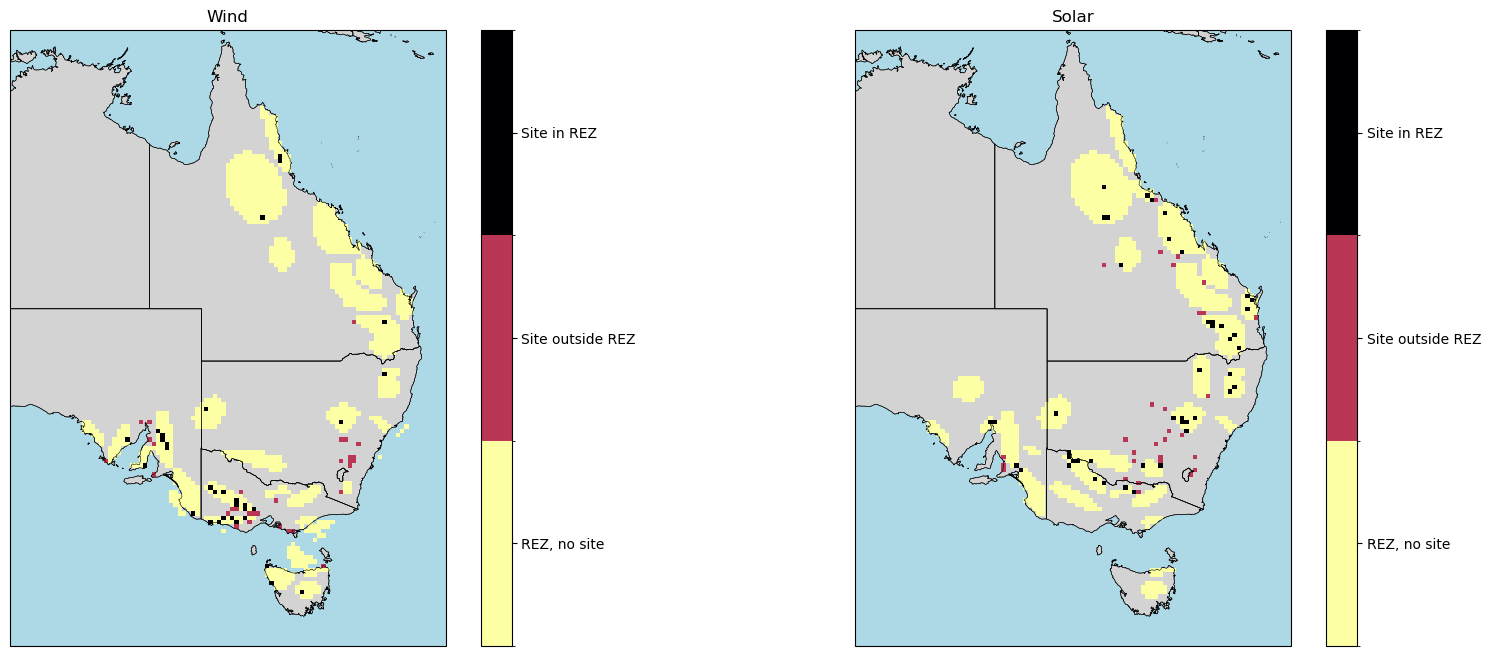

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20,8), subplot_kw={"projection": ccrs.PlateCarree()})

for a in ax.flatten():
    a.set_extent([130, 155, -10, -45])
    a.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='lightgray',
        edgecolor='k',
        lw=.4,
        rasterized=True,
        zorder=0
    )
    a.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='None',
        edgecolor='k',
        lw=.4,
        rasterized=True,
        zorder=2
    )
    a.add_feature(cartopy.feature.OCEAN, facecolor="lightblue")

wind_sites = wind_site_mask.sum("region")
wind_sites = xr.where(wind_sites > 0, 2, 0)

wind_site_plus_rez = wind_sites + rez_mask.sel(region=wind_rez_names).sum("region")
p1 = wind_site_plus_rez.where(wind_site_plus_rez > 0).plot(ax=ax[0], levels=range(1,5), add_colorbar=False, cmap="inferno_r")

cb = plt.colorbar(p1)
cb.set_ticks(np.arange(1.5, 4, 1))
cb.set_ticklabels(["REZ, no site", "Site outside REZ", "Site in REZ"])

ax[0].set_title("Wind")

solar_sites = solar_site_mask.sum("region")
solar_sites = xr.where(solar_sites > 0, 2, 0)

solar_site_plus_rez = solar_sites + rez_mask.sel(region=solar_rez_names).sum("region")
p2 = solar_site_plus_rez.where(solar_site_plus_rez > 0).plot(ax=ax[1], levels=range(1, 5), add_colorbar=False, cmap="inferno_r")

cb = plt.colorbar(p2)
cb.set_ticks(np.arange(1.5, 4, 1))
cb.set_ticklabels(["REZ, no site", "Site outside REZ", "Site in REZ"])

ax[1].set_title("Solar")

#### Some sites are very close to REZs and maybe should be included.

Musselroe in NE Tas, for example, is part of the REZ there. Let's extend the REZ boundaries by one grid cell (~31 km) and include those sites too.

In [36]:
def add_boundary(da):
    """
    Return da with ones around existing ones
    """
    def compute_9_point_average_xarray(arr: xr.DataArray) -> xr.DataArray:
        from scipy.signal import convolve2d
        # Ensure the input is a numpy array
        arr_np = arr.values

        # Define the 3x3 averaging filter
        kernel = np.ones((3, 3)) / 9

        # Use convolve2d to apply the filter
        averaged_arr_np = convolve2d(arr_np, kernel, mode='same', boundary='fill', fillvalue=0)

        # Convert the result back to an xarray DataArray
        averaged_arr = xr.DataArray(averaged_arr_np, dims=arr.dims, coords=arr.coords)

        return averaged_arr
    
    averaged = compute_9_point_average_xarray(da)
    return averaged.where(averaged == 0, 1)

Text(0.5, 1.0, 'Solar')

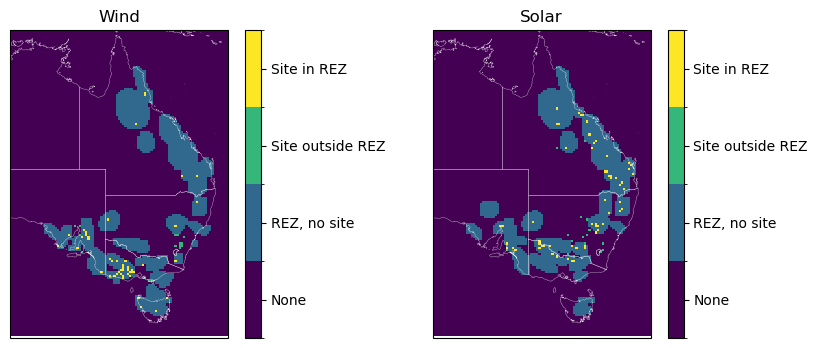

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), subplot_kw={"projection": ccrs.PlateCarree()})

for a in ax.flatten():
    a.set_extent([130, 155, -10, -45])
    a.add_feature(
            cartopy.feature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces',
                scale='10m'
            ),
            facecolor='none',
            edgecolor='w',
            lw=.2,
            rasterized=True
        )

wind_sites = wind_site_mask.sum("region")
wind_sites = xr.where(wind_sites > 0, 2, 0)

wind_rez_extended = add_boundary(rez_mask.sel(region=wind_rez_names).sum("region"))

wind_site_plus_rez = wind_sites + wind_rez_extended
p1 = wind_site_plus_rez.plot(ax=ax[0], levels=range(5), add_colorbar=False)

cb = plt.colorbar(p1)
cb.set_ticks(np.arange(0.5, 4, 1))
cb.set_ticklabels(["None", "REZ, no site", "Site outside REZ", "Site in REZ"])

ax[0].set_title("Wind")

solar_sites = solar_site_mask.sum("region")
solar_sites = xr.where(solar_sites > 0, 2, 0)

solar_rez_extended = add_boundary(rez_mask.sel(region=solar_rez_names).sum("region"))

solar_site_plus_rez = solar_sites + solar_rez_extended
p2 = solar_site_plus_rez.plot(ax=ax[1], levels=range(5), add_colorbar=False)

cb = plt.colorbar(p2)
cb.set_ticks(np.arange(0.5, 4, 1))
cb.set_ticklabels(["None", "REZ, no site", "Site outside REZ", "Site in REZ"])

ax[1].set_title("Solar")

### Re-plot for original REZ boundaries but color sites that are included

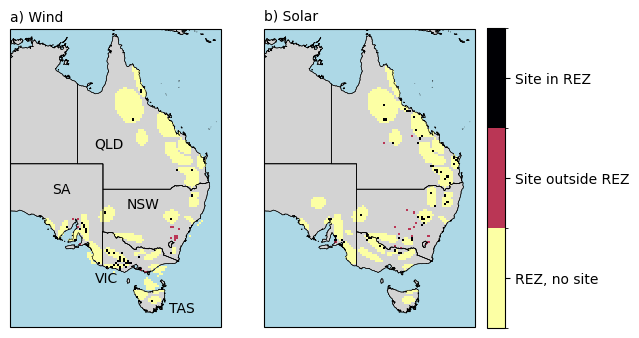

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(6., 4), subplot_kw={"projection": ccrs.PlateCarree()})

for a in ax.flatten():
    a.set_extent([130, 155, -10, -45])
    a.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='lightgray',
        edgecolor='k',
        lw=.4,
        rasterized=True,
        zorder=0
    )
    a.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='None',
        edgecolor='k',
        lw=.4,
        rasterized=True,
        zorder=2
    )
    a.add_feature(cartopy.feature.OCEAN, facecolor="lightblue")

wind_sites = wind_site_mask.sum("region")
wind_sites = xr.where(wind_sites > 0, 2, 0)

wind_rez2 = rez_mask.sel(region=wind_rez_names).sum("region")
wind_rez_extended = add_boundary(rez_mask.sel(region=wind_rez_names).sum("region"))

wind_on_bounds = (wind_rez_extended - wind_rez2 + wind_sites)
wind_on_bounds = xr.where(wind_on_bounds == 3, 1, 0)

wind_site_plus_rez = wind_sites + wind_rez2 + wind_on_bounds
# wind_site_plus_rez = wind_site_plus_rez.where(wind_site_plus_rez > 0)
# wind_site_plus_rez -= 1
p1 = wind_site_plus_rez.where(wind_site_plus_rez > 0).plot(ax=ax[0], levels=range(1,5), add_colorbar=False, cmap="inferno_r")

# cb = plt.colorbar(p1)
# cb.set_ticks(np.arange(0.5, 4, 1))
# cb.set_ticklabels(["None", "REZ, no site", "Site outside REZ", "Site in REZ"])

ax[0].set_title("")
ax[0].set_title("a) Wind", loc="left", fontsize=10)

solar_sites = solar_site_mask.sum("region")
solar_sites = xr.where(solar_sites > 0, 2, 0)

solar_rez2 = rez_mask.sel(region=solar_rez_names).sum("region")
solar_rez_extended = add_boundary(rez_mask.sel(region=solar_rez_names).sum("region"))

solar_on_bounds = (solar_rez_extended - solar_rez2 + solar_sites)
solar_on_bounds = xr.where(solar_on_bounds == 3, 1, 0)

solar_site_plus_rez = solar_sites + solar_rez2 + solar_on_bounds
p2 = solar_site_plus_rez.where(solar_site_plus_rez > 0).plot(ax=ax[1], levels=range(1,5), add_colorbar=False, cmap="inferno_r")

# cb = plt.colorbar(p2)
# cb.set_ticks(np.arange(0.5, 4, 1))
# cb.set_ticklabels(["None", "REZ, no site", "Site outside REZ", "Site in REZ"])

ax[1].set_title("")
ax[1].set_title("b) Solar", loc="left", fontsize=10)

ax[0].text(0.4, 0.6, "QLD", transform=ax[0].transAxes)
ax[0].text(0.55, 0.4, "NSW", transform=ax[0].transAxes)
ax[0].text(0.4, 0.15, "VIC", transform=ax[0].transAxes)
ax[0].text(0.2, 0.45, "SA", transform=ax[0].transAxes)
ax[0].text(0.75, 0.05, "TAS", transform=ax[0].transAxes)

cax = fig.add_axes([0.92, 0.12, 0.03, 0.75])
cbar = fig.colorbar(p1, cax=cax, ticks=np.arange(1.5, 4, 1), orientation="vertical")
cbar.set_ticklabels(["REZ, no site", "Site outside REZ", "Site in REZ"])

# plt.savefig("figures/REZ_map.pdf", format="pdf", bbox_inches="tight")

## Combined

Some sites are outside REZs. What happens when we add REZ power to power from sites outside REZs?

In [39]:
wind_site_plus_rez = wind_sites + wind_rez_extended # rez_mask.sel(region=wind_rez_names).sum("region")

In [40]:
solar_site_plus_rez = solar_sites + solar_rez_extended # rez_mask.sel(region=solar_rez_names).sum("region")

In [41]:
solar_outside = solar_site_mask.where(solar_site_plus_rez == 2)

In [42]:
solar_outside = solar_outside.where(solar_outside > 0, drop=False).to_dataset(name="solar_site")

In [43]:
solar_outside.to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/solar/power/solar_site_outside_REZ_mask_era5.nc",
    mode="w"
)

In [44]:
wind_outside = wind_site_mask.where(wind_site_plus_rez == 2)

In [45]:
wind_outside = wind_outside.where(wind_outside > 0, drop=False).to_dataset(name="wind_site")

In [46]:
wind_outside.to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/power/wind_site_outside_REZ_mask_era5.nc",
    mode="w"
)

#### Compute in other notebook and load power here

In [47]:
wind_outside_rez = xr.open_mfdataset(
    path_power + "site_outside_REZ_power_existing_wind_van_der_Wiel_era5_hourly_1940-2023.nc"
).power

In [48]:
solar_outside_rez = xr.open_mfdataset(
    path_power + "site_outside_REZ_power_existing_solar_van_der_Wiel_era5_hourly_1940-2023.nc"
).power

As we can see, in QLD and VIC there is existing/committed/planned capacity that is not reflected by current sites. We assume this is as-yet-unbuilt capacity.

In other regions, REZ capacity is lower than existing, most likely because there are sites not within REZs. In some cases, these sites should probably be part of REZs e.g. Musselroe, Tasmania.

Everywhere except Tasmania the REZ capacity plus site-outside-REZ capacity is higher than the all-site capacity. This is expected. The strange result in Tasmania is because there is a site that has higher capacity than the REZ amount listed (Cattle Hill 148 MW vs. T3 144 MW).

In [52]:
wind_site

<xarray.DataArray 'power' (region: 5, time: 736344)> Size: 15MB
dask.array<getitem, shape=(5, 736344), dtype=float32, chunksize=(5, 736344), chunktype=numpy.ndarray>
Coordinates:
  * region             (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
  * time               (time) datetime64[ns] 6MB 1940-01-01 ... 2023-12-31T23...
    scale_factor_2023  (region) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>

KeyboardInterrupt: 

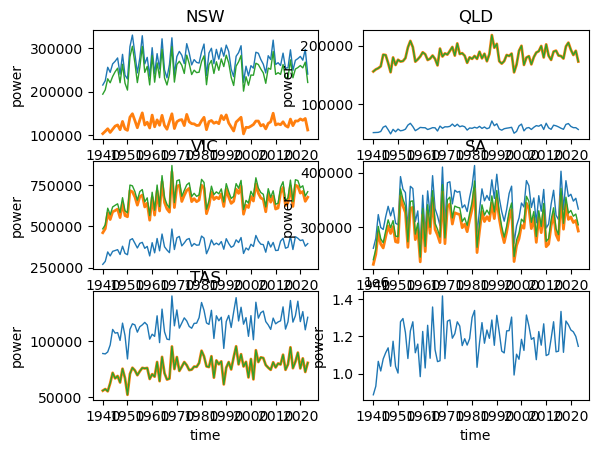

In [61]:
fig, ax = plt.subplots(3, 2)

for i, s in enumerate(regions):
    rezs = get_REZ_for_state(wind_rez, s)
    wind_site.sel(region=s).coarsen(time=24).sum().resample(time="1MS").sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], label="Sites (existing)", lw=1)
    wind_rez.sel(REZ=rezs).sum("REZ").coarsen(time=24).sum().resample(time="1MS").sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], label="REZ (existing + planned)", lw=2)
    (wind_rez.sel(REZ=rezs).sum("REZ") + wind_outside_rez.sel(region=s)).coarsen(time=24).sum().resample(time="1MS").sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], lw=1, label="REZ (existing + planned)\n and sites outside REZs (existing)")
    ax.flatten()[i].set_title(s)
    
# NEM
wind_site.sum("region").coarsen(time=24).sum().resample(time="1MS").sum().resample(time="1YS").mean().plot(ax=ax[2,1], label="Sites (existing)", lw=1)
wind_rez.sum("REZ").coarsen(time=24).sum().resample(time="1MS").sum().resample(time="1YS").mean().plot(ax=ax[2,1], label="REZ (existing + planned)", lw=2)
(wind_rez.sum("REZ") + wind_outside_rez.sum("region")).coarsen(time=24).sum().resample(time="1MS").sum().resample(time="1YS").mean().plot(ax=ax[2,1], lw=1, label="REZ (existing + planned)\n and sites outside REZs (existing)")
ax[2,1].set_title("NEM")

# ax[2,1].axis("off")
plt.tight_layout()
ax[2,0].legend(loc=(0.2, -1.5), ncols=2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


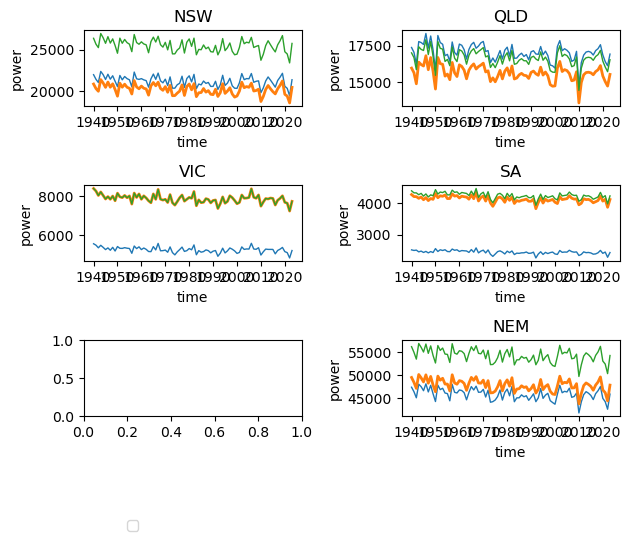

In [60]:
fig, ax = plt.subplots(3, 2)

for i, s in enumerate(regions):
    if s == "TAS":
        pass
    else:
        rezs = get_REZ_for_state(solar_rez, s)
        solar_site.sel(region=s).coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], label="Sites (existing)", lw=1)
        # We have to remove first day, because solar starts at 0700 UTC (underlying radiation data)
        solar_rez.sel(REZ=rezs).sum("REZ").isel(time=range(17, len(solar_rez.time.values))).coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], label="REZ (existing + planned)", lw=2)
        (solar_rez.sel(REZ=rezs).sum("REZ") + solar_outside_rez.sel(region=s)).isel(time=range(17, len(solar_rez.time.values))).coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax.flatten()[i], lw=1, label="REZ (existing + planned)\n and sites outside REZs (existing)")
        ax.flatten()[i].set_title(s)
        
# NEM
solar_site.sum("region").coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax[2,1], label="Sites (existing)", lw=1)
solar_rez.sum("REZ").isel(time=range(17, len(solar_rez.time.values))).coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax[2,1], label="REZ (existing + planned)", lw=2)
(solar_rez.sum("REZ") + solar_outside_rez.sum("region")).isel(time=range(17, len(solar_rez.time.values))).coarsen(time=24).sum().resample(time="1YS").mean().plot(ax=ax[2,1], lw=1, label="REZ (existing + planned)\n and sites outside REZs (existing)")
ax[2,1].set_title("NEM")

plt.tight_layout()
ax[2,1].legend(loc=(0.2, -1.5), ncols=2)

### Correlation between wind and solar

In [47]:
nem_daily_solar_site = solar_site.sum("region").isel(
    time=range(17, len(solar_rez.time.values))
).coarsen(time=24).sum().compute()

In [49]:
nem_daily_wind_site = wind_site.sum("region").isel(
    time=range(24, len(wind_rez.time.values))
).coarsen(time=24).sum().compute()

In [74]:
nem_daily_solar_rez = (solar_rez.sum("REZ") + \
                       solar_outside_rez.sum("region")).isel(
    time=range(17, len(solar_rez.time.values))).coarsen(time=24).sum().compute()

In [75]:
nem_daily_wind_rez = (wind_rez.sum("REZ") + \
                       wind_outside_rez.sum("region")).isel(
    time=range(24, len(wind_rez.time.values))).coarsen(time=24).sum().compute()

In [80]:
from scipy.stats import spearmanr

In [81]:
spearmanr(nem_daily_solar_rez, nem_daily_wind_rez)

SpearmanrResult(correlation=-0.0742212806620667, pvalue=9.691111105550114e-39)

In [82]:
spearmanr(nem_daily_solar_site, nem_daily_wind_site)

SpearmanrResult(correlation=-0.060854981310820136, pvalue=1.4270865335987702e-26)

(0.0, 300000.0)

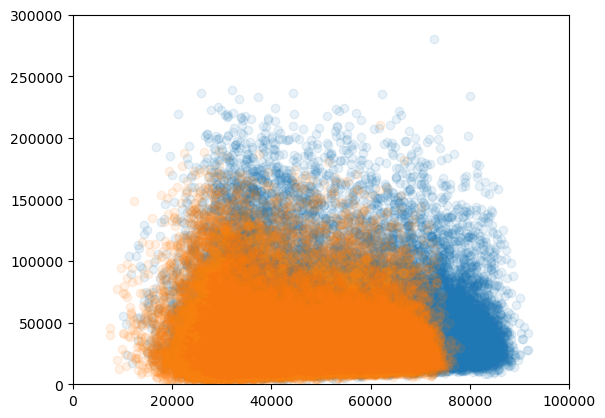

In [85]:
plt.scatter(nem_daily_solar_rez, nem_daily_wind_rez, alpha=0.1)
plt.scatter(nem_daily_solar_site, nem_daily_wind_site, alpha=0.1)
plt.xlim(0, 100000)
plt.ylim(0, 300000)

In [54]:
nem_daily_wind_site

<xarray.DataArray 'power' (time: 30680)>
array([47075.957, 23828.963, 29222.742, ..., 47499.58 , 32439.254,
       23425.543], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-02T11:30:00 ... 2023-12-31T11:30:00

# Close cluster

In [63]:
client.close()
cluster.close()